# Simple Machine Learining Models

Input: single principal component based on all 15 indicators 

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()

In [4]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

In [5]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.append(indicators.values)

x = np.array(x)
x.shape

(288, 6, 27)

In [6]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [7]:
y = []
for i in range(0, len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_tight_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])
    
    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

Cannot get optimal portfolio for 2022-05-06 00:00:00
Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-03-03 00:00:00
Cannot get optimal portfolio for 2023-05-04 00:00:00


(288, 27)

## Splitting data into 80% train and 20% test

In [8]:
test_split = int(0.8 * x.shape[0])

In [9]:
# Train
dates_for_training = days_to_recalculate[:test_split]
print(dates_for_training)

x_train = x[:test_split]
x_train = x_train.reshape(x_train.shape[0], -1)
print(x_train.shape)

y_train = y[:test_split]
print(y_train.shape)

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2018-05-04', '2018-06-05', '2018-07-06', '2018-08-03',
               '2018-09-05', '2018-10-04', '2018-11-06', '2018-12-06',
               '2019-01-10', '2019-02-08'],
              dtype='datetime64[ns]', name='Days to rebalance', length=230, freq=None)
(230, 162)
(230, 27)


In [10]:
# Test
dates_for_test = days_to_recalculate[test_split:]
print(dates_for_test)

x_test = x[test_split:]
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_test.shape)

y_test = y[test_split:]
print(y_test.shape)

DatetimeIndex(['2019-03-05', '2019-04-04', '2019-05-07', '2019-06-05',
               '2019-07-05', '2019-08-06', '2019-09-04', '2019-10-04',
               '2019-11-05', '2019-12-04', '2020-01-09', '2020-02-05',
               '2020-03-04', '2020-04-03', '2020-05-06', '2020-06-03',
               '2020-07-07', '2020-08-05', '2020-09-03', '2020-10-07',
               '2020-11-04', '2020-12-03', '2021-01-06', '2021-02-03',
               '2021-03-03', '2021-04-08', '2021-05-05', '2021-06-03',
               '2021-07-07', '2021-08-04', '2021-09-03', '2021-10-06',
               '2021-11-03', '2021-12-03', '2022-01-11', '2022-02-08',
               '2022-03-04', '2022-04-06', '2022-05-06', '2022-06-07',
               '2022-07-06', '2022-08-03', '2022-09-07', '2022-10-06',
               '2022-11-03', '2022-12-06', '2023-01-09', '2023-02-03',
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
      

## Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
regressor_random_forest = RandomForestRegressor(n_estimators=32,
                                                random_state=42)
regressor_random_forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=32, random_state=42)

Checking example predictions

In [13]:
predictions = regressor_random_forest.predict(x_test)

In [14]:
predictions[0].round(3)

array([0.513, 0.066, 0.059, 0.032, 0.029, 0.024, 0.027, 0.024, 0.009,
       0.01 , 0.015, 0.011, 0.012, 0.014, 0.013, 0.007, 0.009, 0.008,
       0.033, 0.014, 0.014, 0.016, 0.011, 0.009, 0.01 , 0.005, 0.007])

In [15]:
y_test[0]

array([0.576, 0.046, 0.075, 0.023, 0.02 , 0.039, 0.017, 0.016, 0.007,
       0.008, 0.02 , 0.005, 0.02 , 0.02 , 0.004, 0.002, 0.002, 0.002,
       0.024, 0.025, 0.02 , 0.012, 0.006, 0.003, 0.004, 0.002, 0.002])

Checking portfolios to match 1.0

In [16]:
preditions_sum = predictions.sum(axis=1)
preditions_sum

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [17]:
preditions_sum = preditions_sum.reshape(predictions.shape[0], 1)
predictions = np.divide(predictions, preditions_sum)

In [18]:
predictions.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

## Gradient Boosting

In [19]:
import xgboost as xgb

In [20]:
regressor_xg_boosting = xgb.XGBRegressor(n_estimators=32,
                                         random_state=42)
regressor_xg_boosting.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=32, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [21]:
xg_boost_predictions = regressor_xg_boosting.predict(x_test)
xg_boost_predictions.sum(axis=1)

array([0.95003045, 1.0063559 , 1.0020456 , 1.0437537 , 0.94142795,
       0.9332473 , 0.9771983 , 0.9926595 , 1.0716672 , 1.0320423 ,
       1.0341406 , 1.0994397 , 1.0899624 , 0.9780509 , 0.9862272 ,
       0.98372   , 1.1205782 , 1.1548172 , 1.1182473 , 1.1347604 ,
       1.1382921 , 1.1496816 , 1.1233755 , 1.1250135 , 1.1232377 ,
       1.1014608 , 1.1037953 , 1.101491  , 1.0203712 , 1.1603177 ,
       1.1839852 , 1.1366026 , 1.1765342 , 1.1395209 , 1.0208534 ,
       1.043673  , 1.0207177 , 1.0850682 , 1.1043391 , 1.1927415 ,
       1.1135231 , 1.1710804 , 1.1866796 , 1.1625763 , 1.1300591 ,
       1.0853748 , 1.0174505 , 1.0249553 , 1.0322356 , 0.9899999 ,
       1.0797423 , 1.0033929 , 1.0659401 , 1.0375313 , 1.0691608 ,
       1.1342399 , 1.0588102 , 1.0055393 ], dtype=float32)

In [22]:
xg_boost_preditions_sum = xg_boost_predictions.sum(axis=1).reshape(xg_boost_predictions.shape[0], 1)
xg_boost_predictions = np.divide(xg_boost_predictions, xg_boost_preditions_sum)

In [23]:
xg_boost_predictions.sum(axis=1).round(3)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.], dtype=float32)

## Backtesting

In [24]:
from helper_functions import calculate_returns_for_model, calculate_metrics

In [25]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [26]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [27]:
total_returns_random_forest, cum_total_returns_random_forest = calculate_returns_for_model(
    regressor_random_forest, x_test, dates_for_test, df_returns_test, selected_countries)

In [28]:
total_returns_xg_boosting, cum_total_returns_xg_boosting = calculate_returns_for_model(
    regressor_xg_boosting, x_test, dates_for_test, df_returns_test, selected_countries)

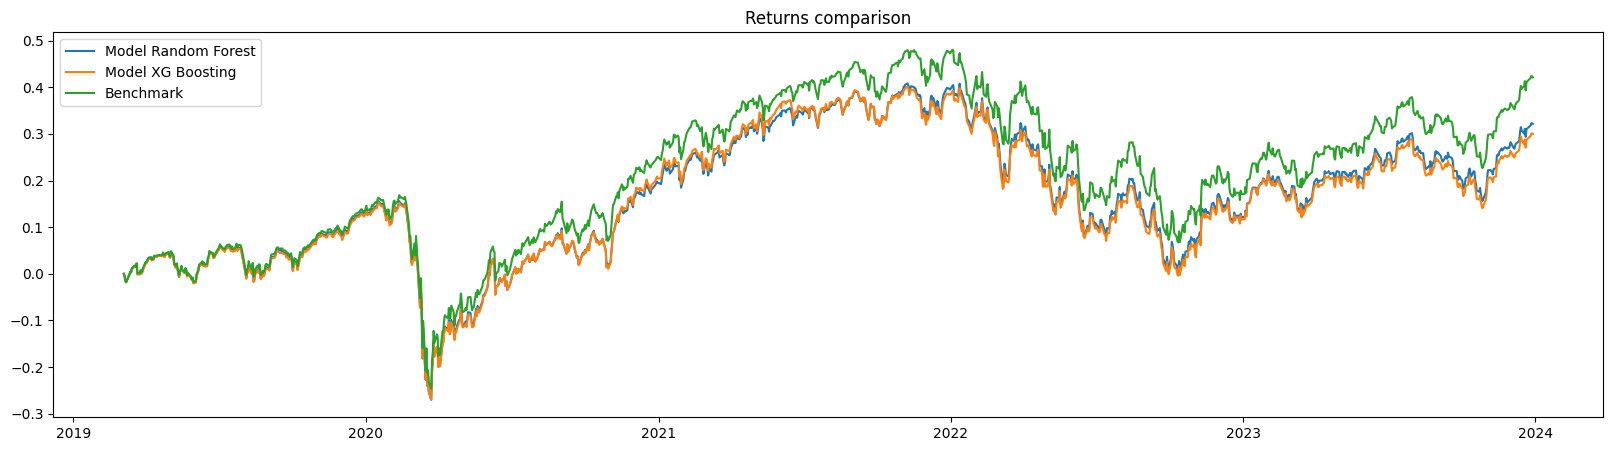

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(cum_total_returns_random_forest, label='Model Random Forest')
plt.plot(cum_total_returns_xg_boosting, label='Model XG Boosting')
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [30]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_random_forest, df_results, 'Model Random Forest', benchmark_returns)
calculate_metrics(total_returns_xg_boosting, df_results, 'Model XG Boosting', benchmark_returns)

df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Model Random Forest,0.059528,0.202518,0.293938,0.340403,-0.368443,538.0,0.161565,-0.655144
Model XG Boosting,0.05597,0.202604,0.276254,0.321425,-0.366288,538.0,0.152804,-0.632785
